# Paleomagnetic Sampling

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import pmagpy.pmag as pmag
import pmagpy.ipmag as ipmag

## Setup 

Our goal is to estimate the paleomagnetic pole $\mu$ for a given period of time or age. For doing so, we are going to recollec a number $N_k$ samples from $K$ different sites, $k=1,2,\ldots,K$. For each site, consequence of secular variation, we are not observing directly $\mu$, but instead $\mu_k$ as a result of secular variations of the magnetic field. If we compute the Fisher mean $\hat \mu_k$ (the hat symbol will be used always for statistical inferences, in opposition to the _true_ value of the pole), then we hope that the new Fisher mean $\hat \mu$ of the $\hat \mu_k$s will give us a estimate for the paleomagnetic poles that will average out the secular variation. The question we are trying to address here is what is the best recollection design of the $N = N_1 + \ldots + N_K$ sample poles that will lead to a better estimation of the final paleomagnetic pole $\mu$. 

We are going to consider the following statistical model for how the sample poles are generated. 
$$
\mu_k \sim \text{Fisher}(\mu, \kappa_\text{secular}) \quad k=1,2,\ldots,K
$$
$$
x_{k,j} \sim \text{Fisher}(\mu_k, \kappa_\text{vgp}) \quad \text{with probability $1-p$ and } 
$$
$$
x_{k,j} \sim \text{Unif}(S^2) \quad \text{otherwise} \quad j=1,2,\ldots,N_k,
$$
where $\kappa_\text{secular}$ and $\kappa_\text{vgp}$ are the dispersion parameters of the Fisher distribution. The parameter $p$ has been added to quantify the effect of outliers in the sampling process. With probability $1-p$ we are going to observe a verical sample of the magnetic field, while with probability $p$ our sample will be corrupted and instead we will observe an spourious medition, modelled by an uniform distribution on the sphere, that is, no information at all about the orientation of the true field. 

We are going to compare two different strategies for estimating the paleomagnetic pole $\mu$:
- Method 1: Compute the Fisher mean of ALL the sample points afor each site and then compute a second Fisher mean of these site vgps to obtain a final estimation of the true paleomagnetic pole.
- Method 2: Assume we are perfectly able to detect outliers, so we can repeat Method 1 after removing those sample points that are clearly ourliers. 

Since we want to know what is the choice of $N_1, N_2, \ldots, N_K$ that will lead to the best estimation of the paleomagnetic pole, we are going to compare these two methods for different strategies. For example, if $N_k$ is large enought then we may be in the case where we can use Method 2, and then we will compare it with the performance of Method 1 when $N_1 = \ldots = N_K = 1$, for example.

## Sampling

Without loss of generallity, we can assumer $\mu=(0,0,1)$. 

In [44]:
from typing import NamedTuple

class Params(NamedTuple):
    
    kappa_vgp : float    
    kappa_secular : float 
    outlier_rate : float
    N_per_site: int
    N : int

In [45]:
def generate_design(params): 
    
    equal_template = np.array([params.N_per_site] * int(params.N/params.N_per_site))
    equal_template[:params.N % params.N_per_site] += 1
    assert np.sum(equal_template) == params.N, 'this happens because there is no way of keeping the right sampling'
    assert np.min(equal_template) >= params.N_per_site
    assert np.max(equal_template) <= params.N_per_site+1
    return equal_template
    
def generate_samples(params):
    '''
    Fuction to generate experimental design 
    
    Arguments:
        - n: total number of samples we are able to recollect
        - n_site: number of samples per site (fixed and constant for all sites for now)
        - p: value between [0,1] representing the probabilty of outlier. 
    Returns:
        - List of number of samples needed to take per site
    '''
    
    design = generate_design(params)
    N_sites = len(design)
    
    # sample secular variations
    secular_declinations, secular_inclinations = ipmag.fishrot(k=params.kappa_secular,
                                                               n=N_sites, 
                                                               dec=0, 
                                                               inc=90, 
                                                               di_block=False)
    
    for i, nk in enumerate(design):
        outliers = np.random.binomial(1, params.outlier_rate, nk)
        outliers = sorted(outliers)
        n_outliers = np.sum(outliers)
        n_samples = nk - n_outliers
        
        # Sample real samples 
        declinations, inclinations = ipmag.fishrot(k=params.kappa_vgp, 
                                                   n=n_samples,
                                                   dec=secular_declinations[i],
                                                   inc=secular_inclinations[i],
                                                   di_block=False)
        
        # Sample outliers 
        declinations_out, inclinations_out = pmag.get_unf(n_outliers).T
        
        declinations = np.concatenate((declinations, declinations_out))
        inclinations = np.concatenate((inclinations, inclinations_out))
        
        df_ = pd.DataFrame({'sample_site': i,
                            'declination': declinations,
                            'inclination': inclinations,
                            'is_outlier': outliers})
        if i==0:
            df = df_
        else:
            df = pd.concat([df, df_], axis=0, ignore_index=True)
            
    return df

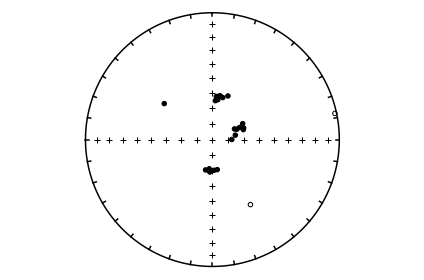

In [46]:
params0 = Params(kappa_vgp=1000,
                kappa_secular=10,
                outlier_rate=0.1,
                N_per_site=6,
                N=25)

df_sample = generate_samples(params0)

ipmag.plot_net(1)
ipmag.plot_di(dec=df_sample.declination.values, inc=df_sample.inclination.values)

In [47]:
### ipmag doesn't return the Fisher mean when the sample has just one point!!!
def robust_fisher_mean(decs, incs):
    assert len(decs) == len(incs)
    if len(decs) == 1:
        return decs[0], incs[0]
    else:
        pole_mean = ipmag.fisher_mean(dec=decs, inc=incs)
        return pole_mean['dec'], pole_mean['inc']
    

def estimate_pole(df_sample, ignore_outliers=False):
    '''
    Function to estimate the Fisher estimate for the paloemagnetic pole
    '''
    if ignore_outliers:
        df = df_sample[df_sample.is_outlier==0]
    else:
        df = df_sample
    
    #df_site = df.groupby('sample_site').apply(lambda row : pd.Series({'declination': ipmag.fisher_mean(dec=row.declination.values, inc=row.inclination.values)['dec'],
    #                                                                  'inclination': ipmag.fisher_mean(dec=row.declination.values, inc=row.inclination.values)['inc']}))
    df_site = df.groupby('sample_site').apply(lambda row : pd.Series({'declination': robust_fisher_mean(row.declination.values, row.inclination.values)[0],
                                                                      'inclination': robust_fisher_mean(row.declination.values, row.inclination.values)[1],
                                                                      'n_samples': len(row.declination.values)}))
    
    # Final fisher mean
    pole_estimate = ipmag.fisher_mean(dec=df_site.declination.values, inc=df_site.inclination.values)
        
    return pole_estimate['dec'], pole_estimate['inc'], df_site.n_samples.sum()

In [13]:
def simulate_estimations(params, n_iters=100, ignore_outliers=False):

    poles_dec, poles_inc, all_total_samples = [], [], []

    for _ in range(n_iters):

        df_sample = generate_samples(params)
        pole_dec, pole_inc, total_samples = estimate_pole(df_sample, ignore_outliers=ignore_outliers)
        poles_dec.append(pole_dec)
        poles_inc.append(pole_inc)
        all_total_samples.append(total_samples)

    df_poles = pd.DataFrame({'declination': poles_dec, 
                             'inclination': poles_inc, 
                             'total_samples': all_total_samples})
    df_poles['error_angle'] = 90.0 - df_poles.inclination
    
    return df_poles

In [40]:
%%time

kappa_vgp = 10
kappa_secular = 1
outlier_rate = 0.2
N = 100
n_iters = 500

params1 = Params(kappa_vgp=kappa_vgp,
                 kappa_secular=kappa_secular,
                 outlier_rate=outlier_rate,
                 N_per_site=7,
                 N=N)

params2 = Params(kappa_vgp=kappa_vgp,
                 kappa_secular=kappa_secular,
                 outlier_rate=outlier_rate,
                 N_per_site=1,
                 N=N)

df_standard = simulate_estimations(params1, n_iters=n_iters, ignore_outliers=True)
df_simple_sample = simulate_estimations(params2, n_iters=n_iters, ignore_outliers=False)

CPU times: user 1min 26s, sys: 43.4 ms, total: 1min 26s
Wall time: 1min 26s


Text(0.65, 0.95, '$RMSE Method 1=29.57$\n$RMSE Method 2=21.12$')

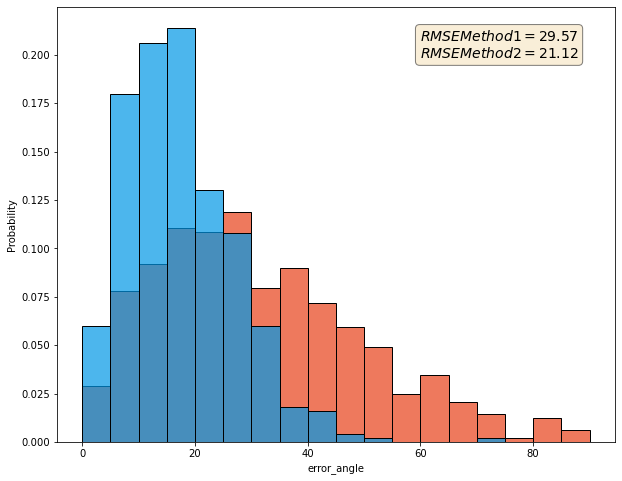

In [43]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(10,8))

sns.histplot(df_standard.error_angle, ax=axes, color='#e84118', stat='probability', binwidth=5, binrange=(0,90), alpha=.7)
sns.histplot(df_simple_sample.error_angle, ax=axes, color='#0097e6', stat='probability', binwidth=5, binrange=(0,90), alpha=.7)


textstr = '\n'.join((
r'$RMSE Method 1=%.2f$' % (np.linalg.norm(df_standard.error_angle)**0.5, ),
r'$RMSE Method 2=%.2f$' % (np.linalg.norm(df_simple_sample.error_angle)**0.5, )))
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
# place a text box in upper left in axes coords
plt.text(0.65, 0.95, textstr, transform=axes.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)